# Dreem Project : Slow Oscillation Prediction

In [2]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import h5py
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
import scipy
import pywt
from collections import Counter
from plotly import tools
from plotly.offline import init_notebook_mode, iplot, plot
import cufflinks as cf
import plotly.graph_objs as go
from datetime import datetime
from datetime import timedelta
import warnings
import time
warnings.filterwarnings('ignore')

## <font color='darkblue'> 1)  Data Collection and pre-processing <font>

In [3]:
root_path = "data/"

In [4]:
# or find datasets in google colab (charbseif@gmail.com)

#from google.colab import drive
#drive.mount('/content/gdrive/')
#root_path = 'gdrive/My Drive/Datasets/'

In [4]:
y_train = pd.read_csv(root_path + "y_train.csv").as_matrix()[:, 1].squeeze()
X_train = h5py.File(root_path + "X_train.h5", "r")
df_train = pd.DataFrame(data=X_train["features"][:])

### a) Labeling columns

In [5]:
def label_columns(df):
    
    l_columns = ['num_pso', 
              'mean_amp_pso',
              'mean_dur_pso',
              'amp_cso',
              'dur_cso',
              'curr_sleep_stage',
              'time_since_sleep',
              'time_in_ds',
              'time_in_ls',
              'time_in_rs',
              'time_in_ws']
    for i in range(12, 1261+1):
        l_columns.append('eeg_signal_%s'%(i-12+1))
    df.columns = l_columns

    return df

In [6]:
label_columns(df_train)

,num_pso,mean_amp_pso,mean_dur_pso,amp_cso,dur_cso,curr_sleep_stage,time_since_sleep,time_in_ds,time_in_ls,time_in_rs,...,eeg_signal_1241,eeg_signal_1242,eeg_signal_1243,eeg_signal_1244,eeg_signal_1245,eeg_signal_1246,eeg_signal_1247,eeg_signal_1248,eeg_signal_1249,eeg_signal_1250
0,237.0,152.658761,341.523207,128.017491,429.0,3.0,11379.0,2730.0,3780.0,0.0,...,22.707487,15.042639,9.706864,7.305480,5.344436,2.674903,-0.055816,-1.212385,-2.461937,-4.930397
1,176.0,146.883435,338.039773,119.130849,196.0,2.0,6721.0,2580.0,2100.0,0.0,...,2.839801,3.458973,4.441102,3.975107,1.000240,2.870631,7.071897,7.848365,4.033517,-2.110046
2,456.0,152.376541,335.629386,164.292580,417.0,2.0,26832.0,3240.0,7440.0,2130.0,...,27.093293,22.821611,14.196937,5.708701,-0.753271,-5.627993,-9.804085,-12.863908,-11.951175,-5.531799
3,21.0,139.720772,336.285714,159.237082,407.0,3.0,1289.0,0.0,60.0,0.0,...,28.191571,25.032295,17.296456,6.335396,-4.008689,-8.589818,-5.876062,0.166707,6.054539,12.086351
4,72.0,140.649432,349.875000,130.184278,297.0,3.0,2262.0,630.0,960.0,0.0,...,-7.942308,-10.407617,-3.418883,9.222596,21.236168,28.245889,27.024864,17.794644,7.602379,-4.548318
5,164.0,144.847843,337.237805,252.473489,394.0,2.0,6381.0,2580.0,1740.0,0.0,...,0.382737,3.833959,6.645052,10.463593,13.190432,12.864986,9.890164,4.352373,-1.054502,-5.224108
6,260.0,152.699259,338.865385,215.023977,331.0,2.0,13614.0,2730.0,4470.0,0.0,...,12.253284,14.861523,17.448599,19.673640,21.139325,20.590147,16.902844,9.947240,3.201194,-3.086158
7,113.0,143.275214,346.601770,122.776337,297.0,3.0,3058.0,1860.0,960.0,0.0,...,10.413213,11.558270,10.148593,5.652390,1.728300,1.746352,3.019379,2.473319,0.993924,-1.379761
8,159.0,144.166783,337.245283,131.431768,314.0,2.0,6216.0,2580.0,1590.0,0.0,...,19.468976,18.654257,17.580130,14.152408,7.379240,-1.661259,-7.683012,-9.873958,-11.299131,-13.039043
9,31.0,139.709626,345.967742,126.789608,420.0,3.0,1511.0,0.0,360.0,0.0,...,8.900036,16.335863,18.984523,16.972549,12.041149,1.502789,-11.907635,-20.536992,-19.681660,-11.282594


## <font color='darkblue'> 2) Data Visualization & Exploration <font>

### a) Visualization of various EEG signals

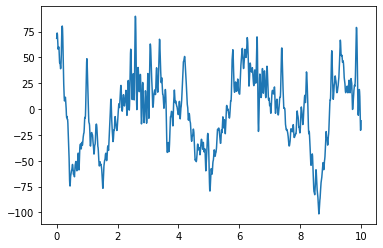

In [7]:
df_signal = df_train.loc[:, 'eeg_signal_1':'eeg_signal_1250']
t = np.linspace(0,10,1250)
plt.plot(t,df_signal.iloc[9,:])

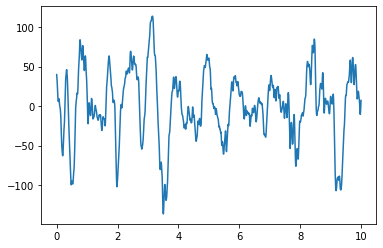

In [8]:
plt.plot(t,df_signal.iloc[56323,:])

### b) Distribution of classes for phases 2 and 3

**This exploration between patients in NREM2 and NREM3 is motivated by the different physical properties of these two stages**

In [ ]:
df_count = df_train_final.copy()
df_count.groupby(['curr_sleep_stage_2.0'])[var_to_pred].value_counts() #more 0s for phase 2 and more 1s and 2s for phase 3

curr_sleep_stage_2.0  SO
0                     1     47982
                      2     44361
                      0     37925
1                     0     76107
                      1     30638
                      2     24621
Name: SO, dtype: int64

**Indeed, we observe that in NREM2, you are more lucky to not have any slow oscillation in the next second compared to NREM3**

## <font color='darkblue'> 3) Data Engineering <font>

### a) Adding base features (mean, max, min)

In [ ]:
def extract_features_base(df):
    
    #compute new columns
    df["mean"] = np.mean(df.loc[:, 'eeg_signal_1':],axis=1)
    df["min"] = np.min(df.loc[:, 'eeg_signal_1':],axis=1)
    df["max"] = np.max(df.loc[:, 'eeg_signal_1':],axis=1)

    #extract columns
    df_final = df.loc[:, :'time_in_ws']
    df_final["mean"] = df.loc[:,"mean"]
    df_final["max"] = df.loc[:,"max"]
    df_final["min"] = df.loc[:,"min"]
    
    return df_final

df_train_final = extract_features_base(df_train)

In [ ]:
df_train_final.head()

,num_pso,mean_amp_pso,mean_dur_pso,amp_cso,dur_cso,curr_sleep_stage,time_since_sleep,time_in_ds,time_in_ls,time_in_rs,time_in_ws,mean,max,min
0,237.0,152.658761,341.523207,128.017491,429.0,3.0,11379.0,2730.0,3780.0,0.0,480.0,11.409497,211.599465,-258.301643
1,176.0,146.883435,338.039773,119.130849,196.0,2.0,6721.0,2580.0,2100.0,0.0,480.0,-1.222639,70.103670,-97.923331
2,456.0,152.376541,335.629386,164.292580,417.0,2.0,26832.0,3240.0,7440.0,2130.0,750.0,3.547349,117.154570,-121.882075
3,21.0,139.720772,336.285714,159.237082,407.0,3.0,1289.0,0.0,60.0,0.0,450.0,-0.119429,92.368167,-110.453401
4,72.0,140.649432,349.875000,130.184278,297.0,3.0,2262.0,630.0,960.0,0.0,450.0,1.421637,105.522241,-119.812297


### b) Adding Entropy's variables (using Raphael Vallat's package)

In [ ]:
from entropy import *

df_train_final["perm_entropy"] = df_train.loc[:, 'eeg_signal_1':].apply(lambda x: perm_entropy(x, order=3, normalize=True), axis=1)
df_train_final["svd_entropy"] = df_train.loc[:, 'eeg_signal_1':].apply(lambda x: svd_entropy(x, order=3, delay=1, normalize=True), axis=1)
df_train_final["higuchi_fd"] = df_train.loc[:, 'eeg_signal_1':].apply(lambda x: higuchi_fd(x, kmax=10), axis=1)
df_train_final["detrended_fluctuation"] = df_train.loc[:, 'eeg_signal_1':].apply(lambda x: detrended_fluctuation(x), axis=1)

In [ ]:
df_train_final.head()

,num_pso,mean_amp_pso,mean_dur_pso,amp_cso,dur_cso,curr_sleep_stage,time_since_sleep,time_in_ds,time_in_ls,time_in_rs,time_in_ws,mean,max,min,perm_entropy,svd_entropy,higuchi_fd,detrended_fluctuation
0,237.0,152.658761,341.523207,128.017491,429.0,3.0,11379.0,2730.0,3780.0,0.0,480.0,11.409497,211.599465,-258.301643,0.728267,0.342592,1.275086,1.678507
1,176.0,146.883435,338.039773,119.130849,196.0,2.0,6721.0,2580.0,2100.0,0.0,480.0,-1.222639,70.103670,-97.923331,0.756092,0.535558,1.377621,1.445956
2,456.0,152.376541,335.629386,164.292580,417.0,2.0,26832.0,3240.0,7440.0,2130.0,750.0,3.547349,117.154570,-121.882075,0.774415,0.402331,1.403614,1.548072
3,21.0,139.720772,336.285714,159.237082,407.0,3.0,1289.0,0.0,60.0,0.0,450.0,-0.119429,92.368167,-110.453401,0.733231,0.483922,1.335530,1.430026
4,72.0,140.649432,349.875000,130.184278,297.0,3.0,2262.0,630.0,960.0,0.0,450.0,1.421637,105.522241,-119.812297,0.764846,0.446307,1.354167,1.497231


### c) Adding Fourrier decomposition using FFT

In [ ]:
n_fft = 64
newcolumns = ['fft_%s'%(i) for i in range(0,n_fft)]
df_train_final[newcolumns] = df_train.loc[:, 'eeg_signal_1':].apply(lambda x: pd.Series(np.abs(np.fft.fft(x, n=n_fft, axis=-1, norm=None))), axis=1)

In [ ]:
df_train_final.head()

,num_pso,mean_amp_pso,mean_dur_pso,amp_cso,dur_cso,curr_sleep_stage,time_since_sleep,time_in_ds,time_in_ls,time_in_rs,time_in_ws,mean,max,min,perm_entropy,svd_entropy,higuchi_fd,detrended_fluctuation,fft_0,fft_1,fft_2,fft_3,fft_4,fft_5,fft_6,fft_7,fft_8,fft_9,fft_10,fft_11,fft_12,fft_13,fft_14,fft_15,fft_16,fft_17,fft_18,fft_19,fft_20,fft_21,...,fft_24,fft_25,fft_26,fft_27,fft_28,fft_29,fft_30,fft_31,fft_32,fft_33,fft_34,fft_35,fft_36,fft_37,fft_38,fft_39,fft_40,fft_41,fft_42,fft_43,fft_44,fft_45,fft_46,fft_47,fft_48,fft_49,fft_50,fft_51,fft_52,fft_53,fft_54,fft_55,fft_56,fft_57,fft_58,fft_59,fft_60,fft_61,fft_62,fft_63
0,237.0,152.658761,341.523207,128.017491,429.0,3.0,11379.0,2730.0,3780.0,0.0,480.0,11.409497,211.599465,-258.301643,0.728267,0.342592,1.275086,1.678507,8949.191326,2881.469101,1202.252894,897.478162,611.400833,581.554347,362.213072,414.566139,255.368381,296.043320,288.175853,217.621704,227.412481,205.031971,212.527834,193.929864,169.877578,172.685133,165.234397,156.521787,149.733393,142.727701,...,135.882122,133.465999,131.455544,129.997759,126.199693,128.372692,125.865203,126.757305,125.637924,126.757305,125.865203,128.372692,126.199693,129.997759,131.455544,133.465999,135.882122,140.214195,140.152954,142.727701,149.733393,156.521787,165.234397,172.685133,169.877578,193.929864,212.527834,205.031971,227.412481,217.621704,288.175853,296.043320,255.368381,414.566139,362.213072,581.554347,611.400833,897.478162,1202.252894,2881.469101
1,176.0,146.883435,338.039773,119.130849,196.0,2.0,6721.0,2580.0,2100.0,0.0,480.0,-1.222639,70.103670,-97.923331,0.756092,0.535558,1.377621,1.445956,466.097649,95.512874,128.319558,128.155812,88.206012,152.899871,156.173110,80.240111,36.995098,25.500161,72.552743,51.015752,5.257660,8.877560,38.671345,21.249483,25.269653,17.218966,27.851879,14.326817,9.385600,14.159857,...,15.806571,13.568157,12.882343,12.953923,12.780604,14.155696,11.483186,12.160236,12.074203,12.160236,11.483186,14.155696,12.780604,12.953923,12.882343,13.568157,15.806571,13.059097,19.142110,14.159857,9.385600,14.326817,27.851879,17.218966,25.269653,21.249483,38.671345,8.877560,5.257660,51.015752,72.552743,25.500161,36.995098,80.240111,156.173110,152.899871,88.206012,128.155812,128.319558,95.512874
2,456.0,152.376541,335.629386,164.292580,417.0,2.0,26832.0,3240.0,7440.0,2130.0,750.0,3.547349,117.154570,-121.882075,0.774415,0.402331,1.403614,1.548072,109.219271,421.929496,73.321368,145.931487,117.260408,142.596567,191.538389,95.946193,72.954328,41.753858,82.851058,133.433396,57.219006,33.725275,25.085414,14.557486,15.726089,18.119736,15.610512,3.949507,6.960730,10.356304,...,9.649904,8.240962,7.714484,8.356595,8.962678,7.283366,7.852109,8.563091,7.234049,8.563091,7.852109,7.283366,8.962678,8.356595,7.714484,8.240962,9.649904,8.704032,7.978563,10.356304,6.960730,3.949507,15.610512,18.119736,15.726089,14.557486,25.085414,33.725275,57.219006,133.433396,82.851058,41.753858,72.954328,95.946193,191.538389,142.596567,117.260408,145.931487,73.321368,421.929496
3,21.0,139.720772,336.285714,159.237082,407.0,3.0,1289.0,0.0,60.0,0.0,450.0,-0.119429,92.368167,-110.453401,0.733231,0.483922,1.335530,1.430026,1115.678852,502.726750,561.917518,469.225618,237.854640,229.645919,101.155184,53.049434,29.843358,42.161239,4.523127,17.933790,7.825747,28.034722,46.405214,34.031274,12.643645,15.377228,22.085344,22.687700,20.953578,18.046863,...,13.970110,15.559445,14.293345,11.516488,12.619093,13.431550,15.246510,13.438374,12.691468,13.438374,15.246510,13.431550,12.619093,11.516488,14.293345,15.559445,13.970110,9.131628,14.344760,18.046863,20.953578,22.687700,22.085344,15.377228,12.643645,34.031274,46.405214,28.034722,7.825747,17.933790,4.523127,42.161239,29.843358,53.049434,101.155184,229.645919,237.854640,469.225618,561.917518,502.726750
4,72.0,140.649432,349.875000,130.184278,297.0,3.0,2262.0,630.0,960.0,0.0,450.0,1.421637,105.522241,-119.812297,0.764846,0.446307,1.354167,1.497231,1924.900276,995.418749,917.724400,697.254169,215.149291,334.5

### d) Adding Discrete Wawelet Transformation

In [ ]:
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy = scipy.stats.entropy(probabilities)
    return entropy
 
def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]
 
def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]
 
def get_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics

def get_wawelet_features(dataset, waveletname):
    wawelet_features = []
    for signal_no in range(0, len(dataset)):
        features = []
        signal = dataset.loc[signal_no, :]
        list_coeff = pywt.wavedec(signal, waveletname)
        for coeff in list_coeff:
            features += get_features(coeff)
            
        wawelet_features.append(features)
    X = pd.DataFrame(wawelet_features)
    waweletscolumns = ['wawelets_%s'%(i) for i in range(0, 96)]
    X.columns=waweletscolumns
    return X

In [ ]:
wawelets = get_wawelet_features(df_train.loc[:, 'eeg_signal_1':'eeg_signal_1250'],"db5")
df_train_final = pd.concat([df_train_final,wawelets],axis=1)

### e) Adding dummies for sleep stages

In [ ]:
df_train_final = pd.get_dummies(df_train_final, prefix=['curr_sleep_stage'], columns=['curr_sleep_stage']) 

### f) Adding outcome variable in the dataframe

In [ ]:
var_to_pred = 'SO'
y_train = pd.DataFrame(y_train, columns=[var_to_pred], index=df_train.index) #!important to keep same index
df_train_final[var_to_pred] = y_train[var_to_pred]

### g) Adding Spindle detection using YASA package

In [ ]:
import yasa
import logging
logging.getLogger("imported_module").setLevel(logging.ERROR)

sf = 125.
data = df_train.loc[:, 'eeg_signal_1':]
df_train_final['spindles'] = data.apply(lambda x: 1 if isinstance(yasa.spindles_detect(x, sf), pd.DataFrame) else 0, axis=1)
sp = yasa.spindles_detect(data.loc[1], sf)
sp

,Start,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry
0,4.08,4.704,0.624,94.947169,18.661034,2.507613,0.336414,12.808329,8.0,0.531646


## h) Transforming Time-Series into Images using Continous Wawelet Transform

**Using Continous Wawelet Transform for integer frequencies between 1Hz and 40Hz, we transform each time-serie in an image**

In [9]:
eegcolumns = ['eeg_signal_%s'%(i-12+1) for i in range(12, 1261+1)]
cols=list(df_train.columns)
selected_var=[c for c in eegcolumns]

In [ ]:
n_image_train=df_train[selected_var].shape[0]
scales = range(1,41)
start = time.time()
Array_images=np.ndarray(shape=(n_image_train, 40, 1250),dtype=np.uint8)
for i in range(0,n_image_train):
    Array_images[i, :, :] = (abs(pywt.cwt(df_train[selected_var].iloc[i,:], scales,"morl", 1/125)[0]))**2
    max_image_i=np.max(Array_images[i, :, :])
    #conversion to an integer between 0 and 255 (8 bits encoding
    Array_images[i, :, :]=((Array_images[i, :, :] / max_image_i) * 255).astype(np.uint8) 

**Transforming our 3D array matrix of images into a 2D Dataframe**

In [ ]:
df_images_2D=pd.Panel(np.rollaxis(Array_images,2)).to_frame()

In [ ]:
df_images_2D.to_hdf('original_data/df_images_final.h5', key='df_images_final')

**The h5 file requires more than 13Gb of disk space and the same in RAM to process it**
\
**Without converting it into 8bits integer, it would have required more than 100Gb of RAM**

## i) Detecting slow waves

In [ ]:
# number of slow oscillations
sf = 125
data = df_train.loc[:, 'eeg_signal_1':]

sw = yasa.sw_detect(data.loc[1], sf)
sw

## j) Target encoding curr sleep stage

In [ ]:
df_train_final['curr_sleep_stage'] = df_train['curr_sleep_stage']
means = df_train_final.groupby('curr_sleep_stage')[var_to_pred].mean()
df_train_final['curr_sleep_stage'] = df_train_final['curr_sleep_stage'].map(means)

## k) Focus fft 2 dernières secondes

In [ ]:
#using Fourrier decomposition
n_fft=64
newcolumns = ['fft_2_sec_%s'%(i) for i in range(0,n_fft)]
df_train_final[newcolumns]=df_train.loc[:, 'eeg_signal_1000':].apply(lambda x: pd.Series(np.abs(np.fft.fft(x, n=n_fft, axis=-1, norm=None))), axis=1)

## <font color='darkblue'> 4) Data Exportation <font>

**As these previous steps take several hours to run, we choose to save it in a h5 file so that we don't have to rerun every steps each time**

In [37]:
df_train_final.to_hdf(root_path+'df_train_final.h5', key='df_train_final')

**RUN IT FROM HERE**

In [ ]:
root_path = ""

In [7]:
df_train_final = pd.read_hdf(root_path+'df_train_final.h5', 'df_train_final')

## <font color='darkblue'> 5) Data Prediction <font>

### a) Splitting data into train and validation sets

In [8]:
var_to_pred = 'SO'
X_train, X_val, y_train, y_val = train_test_split(df_train_final.loc[:, df_train_final.columns != var_to_pred], df_train_final[var_to_pred], test_size=0.10,random_state=0, stratify=df_train_final[var_to_pred])
y_train = pd.DataFrame(y_train)
y_val = pd.DataFrame(y_val)

### b) Defining Models

**We define differents models to choose easily the predictors we want to select for each algorithm**

In [42]:
equations = {
  
     'base_model': {'predictors': list(df_train_final.columns)[0:13]},
     'entropy_fft': {'predictors': list(df_train_final.columns[0:81])},
     'dummy_variables_only': {'predictors': list(df_train_final.columns)[0:11]+list(df_train_final.columns)[81:83]},
     'dummy_variables': {'predictors': list(df_train_final.columns)[0:83]},
    
     'wawelets': {'predictors': list(df_train_final.columns[0:17])+list(df_train_final.columns[85:181])},
     'wawelets_spindles':{'predictors': list(df_train_final.columns[0:17])+list(df_train_final.columns[85:182])},

     'fft_wawelets' : {'predictors': list(df_train_final.columns[0:81])+list(df_train_final.columns[85:181])},
     'fft_wawelets_spindles': {'predictors': list(df_train_final.columns[0:81])+list(df_train_final.columns[85:182])},
}

cols_eq = list(equations.keys())

### c) Baseline Model

**We use as Baseline Model a Random Forest on the base features (10 first features + mean / max / avg of each EEG signal)**

In [43]:
model = 'base_model'
predictors = equations[model]['predictors']

clf = RandomForestClassifier(n_estimators=100 ,random_state=0)
clf.fit(X_train[predictors], y_train)
y_pred = clf.predict(X_val[predictors])

acc_baseline = accuracy_score(y_val, y_pred)
print("The accuracy score of the Baseline Model is "+str(np.round(100*acc_baseline,2))+"%")

The accuracy score of the Baseline Model is 48.77%


In [44]:
X_val[predictors].head()

,num_pso,mean_amp_pso,mean_dur_pso,amp_cso,dur_cso,time_since_sleep,time_in_ds,time_in_ls,time_in_rs,time_in_ws,mean,max,min
242900,891.0,180.347850,334.845118,275.630795,363.0,12995.0,8040.0,12900.0,2610.0,1410.0,2.953645,175.370963,-138.381252
102875,45.0,152.590498,262.533333,184.771281,383.0,906.0,0.0,0.0,0.0,1320.0,2.058040,103.933505,-114.235098
221938,239.0,149.525059,329.447699,345.370173,407.0,11312.0,4560.0,960.0,1230.0,390.0,-7.104443,248.680073,-338.203135
208356,319.0,173.571274,286.771160,163.356485,238.0,12932.0,3300.0,3990.0,1080.0,1170.0,4.134927,202.549573,-101.815879
238811,176.0,154.426726,317.602273,219.596660,374.0,20366.0,360.0,3840.0,0.0,1050.0,-1.169126,96.789840,-162.464551


### d) Random Forest using FFT and Entropy's predictors

In [45]:
model = 'entropy_fft'
predictors = equations[model]['predictors']

clf = RandomForestClassifier(n_estimators=100 ,random_state=0)
clf.fit(X_train[predictors], y_train)
y_pred = clf.predict(X_val[predictors])

acc_rf_fft = accuracy_score(y_val, y_pred)
print("The accuracy score of the Random Forest using FFT and Entropy's predictors is "+str(np.round(100*acc_rf_fft,2))+"%")

The accuracy score of the Random Forest using FFT and Entropy's predictors is 49.52%


###  e) XGBoost using FFT and Discrete Wawelets Transform

In [46]:
model='fft_wawelets'
predictors = equations[model]['predictors']

dtrain = xgb.DMatrix(data=X_train[predictors], label=y_train)
dval = xgb.DMatrix(data=X_val[predictors])

# Parameters obtained by HyperTuning (GridSearch)
params = {
    'max_depth': 7,
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 3,
    'lambda': 0.1
}

bst = xgb.train(params, dtrain)
y_pred = bst.predict(dval)

acc_xgb_wawelets = accuracy_score(y_val, y_pred)
print("The accuracy score of the Baseline Model is "+str(np.round(100*acc_xgb_wawelets,2))+"%")

The accuracy score of the Baseline Model is 51.76%


In [47]:
pd.Series(y_pred).value_counts()

0.0    15737
1.0     5853
2.0     4574
dtype: int64

###  f) CNN using Continous Wawelet Transform

In [5]:
df_images_final_2D = pd.read_hdf('original_data/df_images_final.h5', 'df_images_final')

**Retransforming the 2D Dataframe into our 3D array matrix of images**

In [6]:
df_images_final = np.rollaxis(np.rollaxis(df_images_final_2D.to_panel().values,2),2)

**Visualization of one image**

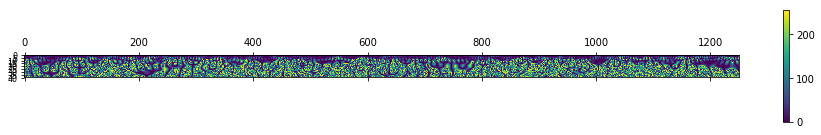

In [36]:
import matplotlib.pyplot as plt
plt.matshow(df_images_final[6,:,:])
plt.yticks(fontsize=8)
plt.colorbar()
plt.show()

**Separation in Train/Validation Sets**

In [7]:
y_train_ = pd.read_csv("original_data/y_train.csv").as_matrix()[:, 1].squeeze()
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(df_images_final, y_train_, test_size=0.10,random_state=0, stratify=y_train_)

**Reshaping inputs for Keras**

In [15]:
X_train_cnn=X_train_cnn.reshape(X_train_cnn.shape[0],X_train_cnn.shape[1],X_train_cnn.shape[2],1)
X_val_cnn=X_val_cnn.reshape(X_val_cnn.shape[0],X_val_cnn.shape[1],X_val_cnn.shape[2],1)
y_train_cnn = keras.utils.to_categorical(y_train_cnn, num_classes)
y_val_cnn = keras.utils.to_categorical(y_val_cnn, num_classes)

In [ ]:
import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.models import Sequential
from keras.callbacks import History 
history = History()
 
img_x = 40
img_y = 1250
img_z = 1
input_shape = (img_x, img_y, img_z)
 
num_classes = 3
batch_size = 128
epochs = 2
 
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 5), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(128, (3, 7), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 7), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))
 
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])


model.fit(X_train_cnn, y_train_cnn,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val_cnn, y_val_cnn),
          callbacks=[history])
 
train_score = model.evaluate(X_train_cnn, y_train_cnn, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(X_val_cnn, y_val_cnn, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

Train on 235470 samples, validate on 26164 samples
Epoch 1/2
235470/235470 [==============================] - 2350s 10ms/step - loss: 1.2217 - acc: 0.4351 - val_loss: 1.2200 - val_acc: 0.4359
Epoch 2/2
235470/235470 [==============================] - 2338s 10ms/step - loss: 1.2150 - acc: 0.4357 - val_loss: 1.2200 - val_acc: 0.4359


In [37]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 40, 1250, 32)      320       
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 38, 1248, 32)      9248      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 19, 624, 32)       0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 19, 624, 32)       0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 19, 624, 64)       30784     
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 17, 620, 64)       61504     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 8, 310, 64)        0         
__________

###  g) CNN-1D on raw data (EEG signals only)

In [11]:
y_train = pd.read_csv(root_path + "y_train.csv").as_matrix()[:, 1].squeeze()
X_train = h5py.File(root_path + "X_train.h5", "r")
df_train = pd.DataFrame(data=X_train["features"][:])
X_train_eeg, X_val_eeg, y_train_eeg, y_val_eeg = train_test_split(df_train[selected_var], y_train_, test_size=0.10,random_state=0, stratify=y_train_)

In [18]:
from keras.utils import to_categorical

# Convert labels to categorical one-hot encoding
y_train_eeg=pd.DataFrame(y_train_eeg)
y_val_eeg=pd.DataFrame(y_val_eeg)
y_train_eeg = to_categorical(y_train_eeg.values, num_classes=3)
y_val_eeg= to_categorical(y_val_eeg.values, num_classes=3)

In [22]:
# we feed 2 downsampled datasets + the original dataset = 3

model_train = [
    X_train_eeg.iloc[:, np.arange(0, 1250, 5)].values[:,:,None], # small
    X_train_eeg.iloc[:, np.arange(0, 1250, 2)].values[:,:,None], # medium
    X_train_eeg.values[:,:,None],                                # original
]

model_val = [
    X_val_eeg.iloc[:, np.arange(0, 1250, 5)].values[:,:,None], # small
    X_val_eeg.iloc[:, np.arange(0, 1250, 2)].values[:,:,None], # medium
    X_val_eeg.values[:,:,None],                                # original
]

**Applying a 1D-CNN on the original dataset + 2 downsampled version of the dataset**

In [29]:
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Input, Concatenate
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Base model
# 3 of them are run in parallel with each a downsampled version of the data
def get_base_model(input_len, kernel_size):
    nb_filters = 20
    
    model = Sequential([
        Conv1D(nb_filters, kernel_size, activation='relu', input_shape=(input_len, 1)),
        Conv1D(nb_filters, kernel_size, activation='relu'),
        MaxPooling1D(10),
        Conv1D(nb_filters*2, kernel_size, activation='relu'),
        Conv1D(nb_filters*2, kernel_size, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(50, activation='relu'),
        Dense(50, activation='relu'),
        Dropout(0.3),
    ])
    
    return model

# Main model
def main_model(inputs_lens = [250, 625, 1250], kernel_sizes = [4, 8, 16]):
    # the inputs to the branches are the original time series, and its down-sampled versions
    input_smallseq = Input(shape=(inputs_lens[0], 1), name='eeg_small')
    input_medseq   = Input(shape=(inputs_lens[1], 1), name='eeg_medium')
    input_origseq  = Input(shape=(inputs_lens[2], 1), name='eeg_original')
    
    # the more down-sampled the time series, the shorter the corresponding filter
    base_net_small    = get_base_model(inputs_lens[0], kernel_sizes[0])
    base_net_med      = get_base_model(inputs_lens[1], kernel_sizes[1])
    base_net_original = get_base_model(inputs_lens[2], kernel_sizes[2])
    
    embedding_small    = base_net_small(input_smallseq)
    embedding_med      = base_net_med(input_medseq)
    embedding_original = base_net_original(input_origseq)
    
    # concatenate all the outputs
    merged = Concatenate()([embedding_small, embedding_med, embedding_original])
    dropped = Dropout(0.5)(merged)
    
    stacked = Dense(64, activation='relu')(dropped)
    stacked = Dense(64, activation='relu')(stacked)
    
    
    # output layer
    out = Dense(3, activation='softmax')(stacked)
    
    model = Model(inputs=[input_smallseq, input_medseq, input_origseq], outputs=out)
    return model

In [30]:
batch_size = 256
epochs = 3

model = main_model()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(model_train, y_train_eeg,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(model_val, y_val_eeg))

Train on 235470 samples, validate on 26164 samples
Epoch 1/3
235470/235470 [==============================] - 1066s 5ms/step - loss: 1.0420 - accuracy: 0.4717 - val_loss: 1.0107 - val_accuracy: 0.4878
Epoch 2/3
235470/235470 [==============================] - 1377s 6ms/step - loss: 1.0037 - accuracy: 0.4949 - val_loss: 0.9965 - val_accuracy: 0.5059
Epoch 3/3
235470/235470 [==============================] - 1539s 7ms/step - loss: 0.9951 - accuracy: 0.5018 - val_loss: 0.9892 - val_accuracy: 0.4996


In [31]:
print(model.summary())

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
eeg_small (InputLayer)          (None, 250, 1)       0                                            
__________________________________________________________________________________________________
eeg_medium (InputLayer)         (None, 625, 1)       0                                            
__________________________________________________________________________________________________
eeg_original (InputLayer)       (None, 1250, 1)      0                                            
__________________________________________________________________________________________________
sequential_22 (Sequential)      (None, 50)           16000       eeg_small[0][0]                  
____________________________________________________________________________________________